In [1]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from torch import nn
import numpy as np
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from functions import MyLSTM, black_process, white_process

In [2]:
torch.set_default_dtype(torch.float64)

# Importing the data

In [3]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    if '' in ls:
        print(f"WHAT THE FUCK : {str}")
    list = [float(i) for i in ls]
    return list

In [4]:
df = pd.read_csv('lichess_db_standard_rated_2023-08_1_1000000.csv', dtype  ={'Eval':'string'})

In [5]:
# filtering out None or empty evaluations
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]
df = df[~df['Eval'].str.contains('None')]
df = df[df['Eval']!='']
df = df[df['Eval'] != '']
df = df[df['Eval'] != '[]']

In [6]:
df.value_counts('TimeControl')

TimeControl
600+0       15404
180+0       14146
60+0        11808
300+0       10071
180+2        9539
            ...  
1080+9          1
720+2           1
7200+120        1
7200+45         1
420+4           1
Name: count, Length: 295, dtype: int64

In [7]:
# picking a time control - I'm looking at 3 minute games
df = df[df["Clock"] != '[]']
df = df[~df["Clock"].str.contains(',,')]

In [8]:
# defining a function to return initial time and increment
def get_init_time(string):
    t = string.split('+')
    return int(t[0])

def get_inc(string):
    t = string.split('+')
    return int(t[1])

In [9]:
# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

# converting the evaluations and clock times to lists
df['Eval'] = df['Eval'].apply( to_list)
df['Clock'] = df['Clock'].apply(to_list)

df['Increment'] = df["TimeControl"].apply(get_inc)
df['Init_time'] = df["TimeControl"].apply(get_init_time)

# processing the evaluations and clock times into feature sequences
df['WhiteEval'] =df.apply(lambda x : white_process(x.Eval, x.Clock, x.Init_time, x.Init_time, x.Increment, x.BlackELO), axis =1 )
df['BlackEval'] = df.apply(lambda x : black_process(x.Eval, x.Clock,x.Init_time,x.Init_time,x.Increment,x.WhiteELO), axis =1 )

In [10]:
df['Clock'].head()

0    [300.0, 300.0, 299.0, 299.0, 298.0, 297.0, 297...
1    [300.0, 300.0, 295.0, 301.0, 293.0, 303.0, 292...
2    [300.0, 300.0, 299.0, 289.0, 276.0, 286.0, 273...
3    [180.0, 180.0, 181.0, 182.0, 183.0, 183.0, 184...
4    [60.0, 60.0, 60.0, 59.0, 59.0, 59.0, 59.0, 58....
Name: Clock, dtype: object

In [11]:
df.Eval

0        [0.0, 27.0, 29.0, 30.0, 16.0, 94.0, -74.0, 64....
1        [0.0, 27.0, 29.0, 30.0, 16.0, 27.0, 15.0, 21.0...
2        [0.0, 98.0, 80.0, 159.0, 23.0, 47.0, 19.0, 942...
3        [0.0, 90.0, 34.0, 30.0, 50.0, 126.0, 98.0, 117...
4        [0.0, 27.0, 13.0, 51.0, 2.0, 35.0, 3.0, 66.0, ...
                               ...                        
86989    [36.0, 32.0, 0.0, 0.0, 14.0, 39.0, 25.0, 45.0,...
86990    [36.0, 35.0, 29.0, 32.0, 21.0, 20.0, 25.0, 152...
86991    [36.0, 35.0, 29.0, 32.0, 21.0, 76.0, 56.0, 98....
86992    [36.0, 32.0, 0.0, 15.0, 0.0, 11.0, 0.0, 0.0, 0...
86993    [0.0, 27.0, 0.0, 6.0, 9.0, 58.0, 39.0, 52.0, 2...
Name: Eval, Length: 86764, dtype: object

In [12]:
df['WhiteEval'].head()

0    [[99.9999, 100.0, 0.0, 0.0, 300.0, 0.0], [100....
1    [[99.9999, 100.0, 0.0, 0.0, 300.0, 3.0], [100....
2    [[99.9999, 100.0, 0.0, 0.0, 300.0, 3.0], [93.0...
3    [[99.9999, 100.0, 0.0, 0.0, 180.0, 2.0], [79.5...
4    [[99.9999, 100.0, 0.0, 0.0, 60.0, 0.0], [94.37...
Name: WhiteEval, dtype: object

In [13]:
df['BlackEval'].head()

0    [[89.42685016134062, 99.9999, 0.0, 0.0, 300.0,...
1    [[89.42685016134062, 99.9999, 0.0, 0.0, 300.0,...
2    [[66.78275170056337, 99.9999, 0.0, 0.0, 300.0,...
3    [[68.99392747162456, 99.9999, 0.0, 0.0, 180.0,...
4    [[89.42685016134062, 99.9999, 0.0, 0.0, 60.0, ...
Name: BlackEval, dtype: object

In [14]:
#copying black's evaluations to the same column as white's, so we examine each game from both perspectives
# NOTE: I'm filtering out some elos between 1200 and  2200 to try to get a larger range of predictions 
df_flipped = df.copy()
df_flipped['WhiteEval'] = df_flipped['BlackEval']
t = df_flipped['WhiteELO'].astype(float)
df_flipped['WhiteELO'] = df_flipped['BlackELO'].astype(float)
df_flipped['BlackELO'] = t
df_flipped['White'] = df_flipped['Black']
#df_flipped = df_flipped[ (df_flipped['WhiteELO'] <1200) | (df_flipped['WhiteELO'] >2200)]
df = pd.concat([df, df_flipped])

In [15]:
# Another idea is to predict the elo difference?

In [16]:
df['BlackELO'][0]

0    1898.0
0    1820.0
Name: BlackELO, dtype: float64

In [17]:
df['WhiteEval'][0]

0    [[99.9999, 100.0, 0.0, 0.0, 300.0, 0.0], [100....
0    [[89.42685016134062, 99.9999, 0.0, 0.0, 300.0,...
Name: WhiteEval, dtype: object

In [18]:
print(len(df))

173528


In [19]:
print(f"Evaluted games: {len(df['Eval'])}")

Evaluted games: 173528


# Regularizing Data

In [20]:
white_x = numpy.array(df['WhiteEval'])
eval_length = numpy.array(df['WhiteEval'].apply(len))

In [21]:
white_x[1]

array([[ 99.9999    , 100.        ,   0.        ,   0.        ,
        300.        ,   3.        ],
       [100.82798467,  89.42685016,   0.        ,   5.        ,
        300.        ,   3.        ],
       [ 94.38060112,  99.58845324,  -1.        ,   2.        ,
        300.        ,   3.        ],
       [ 95.16274216,  95.55731055,  -2.        ,   1.        ,
        300.        ,   3.        ],
       [ 91.67603247,  97.55125425,  -1.        ,   0.        ,
        300.        ,   3.        ],
       [ 79.61542959,  84.74353491,   5.        ,  18.        ,
        300.        ,   3.        ],
       [ 92.85022542,  77.98293274,   2.        ,   0.        ,
        300.        ,   3.        ],
       [ 86.5052653 ,  99.9999    ,  11.        ,   3.        ,
        300.        ,   3.        ],
       [ 99.9999    ,  96.74470664,  -1.        ,   0.        ,
        300.        ,   3.        ],
       [ 98.36377841,  87.9584065 ,   6.        ,   0.        ,
        300.        ,   3. 

In [22]:
eval_length

array([19, 26, 26, ..., 25, 48, 45])

In [23]:
# creating and fitting a power transformer for black and white
eval_pt = StandardScaler()

eval = numpy.concatenate(white_x) # concatenating so that the data has shape (samples,features)

In [24]:
eval[19:45]

array([[ 99.9999    , 100.        ,   0.        ,   0.        ,
        300.        ,   3.        ],
       [100.82798467,  89.42685016,   0.        ,   5.        ,
        300.        ,   3.        ],
       [ 94.38060112,  99.58845324,  -1.        ,   2.        ,
        300.        ,   3.        ],
       [ 95.16274216,  95.55731055,  -2.        ,   1.        ,
        300.        ,   3.        ],
       [ 91.67603247,  97.55125425,  -1.        ,   0.        ,
        300.        ,   3.        ],
       [ 79.61542959,  84.74353491,   5.        ,  18.        ,
        300.        ,   3.        ],
       [ 92.85022542,  77.98293274,   2.        ,   0.        ,
        300.        ,   3.        ],
       [ 86.5052653 ,  99.9999    ,  11.        ,   3.        ,
        300.        ,   3.        ],
       [ 99.9999    ,  96.74470664,  -1.        ,   0.        ,
        300.        ,   3.        ],
       [ 98.36377841,  87.9584065 ,   6.        ,   0.        ,
        300.        ,   3. 

In [25]:
eval_pt.fit(eval)
eval_transformed = eval_pt.transform(eval)

In [26]:
eval_transformed[:45]

array([[ 0.5600182 ,  0.55768692, -0.42188099, -0.4241114 , -0.1487679 ,
        -0.38318537],
       [ 0.59996911,  0.04312264, -0.42188099, -0.34396071, -0.1487679 ,
        -0.38318537],
       [ 0.28891531,  0.53765814, -0.34121374, -0.34396071, -0.1487679 ,
        -0.38318537],
       [-1.86472637, -0.77666127, -0.26054649, -0.34396071, -0.1487679 ,
        -0.38318537],
       [ 0.50130681, -1.56665288, -0.17987925, -0.02335794, -0.1487679 ,
        -0.38318537],
       [ 0.16470652,  0.17724495, -0.26054649, -0.18365932, -0.1487679 ,
        -0.38318537],
       [-0.82426711,  0.08707988, -0.34121374, -0.18365932, -0.1487679 ,
        -0.38318537],
       [ 0.27082345, -0.18450187, -0.26054649, -0.34396071, -0.1487679 ,
        -0.38318537],
       [ 0.34716168,  0.02780749, -0.34121374, -0.26381001, -0.1487679 ,
        -0.38318537],
       [ 0.59442966, -1.79582666, -0.099212  , -0.18365932, -0.1487679 ,
        -0.38318537],
       [-2.94574471, -1.61586929, -0.099212  , -0.

In [27]:
from joblib import dump
dump(eval_pt, 'eval_scaler.bin', compress=True)


['eval_scaler.bin']

<Axes: >

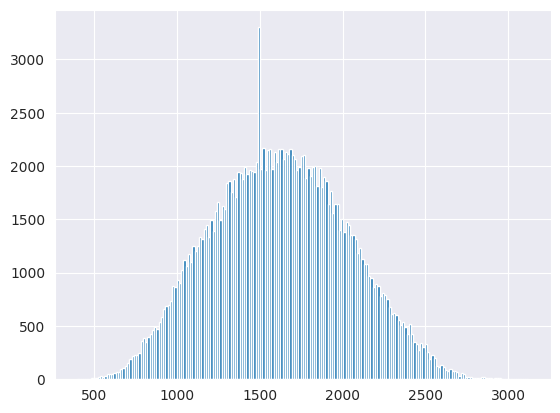

In [28]:
df['WhiteELO'].hist(bins = 200)

In [29]:
df['Target'] = df['WhiteELO']

In [30]:
target_arr = numpy.array(df['Target'])

In [31]:
#welopt = PowerTransformer(method = 'box-cox')
target_pt = StandardScaler()
target_arr = np.reshape(target_arr, (len(target_arr),1))
target_pt.fit(target_arr)
target_transformed = target_pt.transform(target_arr)

(array([   79.,   544.,  2247.,  5066.,  9386., 13141., 16680., 19280.,
        22016., 20858., 19363., 15880., 12139.,  8010.,  5034.,  2557.,
          875.,   244.,    99.,    30.]),
 array([-2.97964143, -2.64739102, -2.31514061, -1.98289021, -1.6506398 ,
        -1.3183894 , -0.98613899, -0.65388858, -0.32163818,  0.01061223,
         0.34286263,  0.67511304,  1.00736344,  1.33961385,  1.67186426,
         2.00411466,  2.33636507,  2.66861547,  3.00086588,  3.33311629,
         3.66536669]),
 <BarContainer object of 20 artists>)

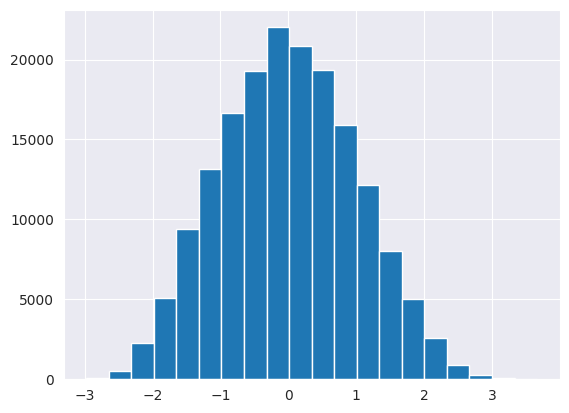

In [32]:
plt.hist(target_transformed, bins =20)

In [33]:
dump(target_pt, 'target_scaler.bin', compress=True)

['target_scaler.bin']

# The next cell is wrong!!

In [34]:
#eval_transformed_array = [numpy.array(list(islice(iter(eval_transformed), elem))) for elem in eval_length]

In [35]:
index = 0
ls = []
for length in eval_length:
    seq = eval_transformed[index: index+length -1]
    ls.append(seq)
    index += length
eval_transformed_array  = ls
    

In [36]:
eval_transformed_array[3]

array([[ 0.5600182 ,  0.55768692, -0.42188099, -0.4241114 , -0.49569227,
         0.1735847 ],
       [-0.42831887, -0.95128794, -0.42188099, -0.50426209, -0.49569227,
         0.1735847 ],
       [ 0.97303483,  0.63853991, -0.58321548, -0.58441278, -0.49569227,
         0.1735847 ],
       [ 0.05243832, -0.72983901, -0.50254823, -0.50426209, -0.49569227,
         0.1735847 ],
       [-0.47918537,  0.20311048, -0.58321548, -0.50426209, -0.49569227,
         0.1735847 ],
       [-0.29682199, -0.15543346, -0.42188099, -0.50426209, -0.49569227,
         0.1735847 ],
       [ 0.59973693,  0.53775809, -0.58321548, -0.50426209, -0.49569227,
         0.1735847 ],
       [ 0.48204303,  0.21233179, -0.50254823, -0.50426209, -0.49569227,
         0.1735847 ],
       [-0.08679334,  0.57756339, -0.42188099, -0.50426209, -0.49569227,
         0.1735847 ],
       [-0.4531434 , -1.40617313, -0.26054649, -0.34396071, -0.49569227,
         0.1735847 ],
       [ 0.67685651,  0.49959379, -0.42188099, -0.

In [37]:
target_transformed[3]

array([0.50770572])

# Splitting data into a training and test set

In [38]:
# converting evaluations and length to tensors
evals = [torch.tensor(i, dtype = torch.float64) for i in eval_transformed_array]
lengths = [len(tensor) for tensor in evals]



In [39]:
def avg_cpl(white_processed):
    '''
    return the average centipawn loss from an evaluated game
    :param white_processed: list of lists of the form [evaluation, centipawn loss]
    :return: average centipawn loss (float)
    '''
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [40]:
df['White_avg_cpl'] = df['WhiteEval'].copy().apply( avg_cpl )

In [41]:
X = df[['White_avg_cpl']]
print(len(X))

173528


In [42]:
# Converting White and Black's ELOs to tensors
target = [torch.tensor(i, dtype = torch.float64) for i in target_transformed]

average_cpl = np.array(df['White_avg_cpl'])

# splitting into train and test
eval_train, eval_test, target_train, target_test, average_cpl_train, average_cpl_test, X_train,X_test = train_test_split(evals,target, average_cpl, X, test_size=0.2,random_state=0, shuffle = True)

In [43]:
# zipping together the features and targets
train_data_zip = list(zip(eval_train, target_train))
test_data_zip = list(zip(eval_test, target_test))

In [44]:
train_data_zip[0]

(tensor([[ 1.3314e+00,  5.5769e-01, -4.2188e-01, -4.2411e-01,  4.1878e+00,
           7.9684e+00],
         [ 4.4216e-01,  5.7776e-01, -4.2188e-01, -2.6683e+00,  4.1878e+00,
           7.9684e+00],
         [ 5.9993e-01,  4.9786e-01, -2.6806e+00, -2.6683e+00,  4.1878e+00,
           7.9684e+00],
         [ 1.3455e+00,  4.3893e-01, -2.5999e+00, -2.6683e+00,  4.1878e+00,
           7.9684e+00],
         [ 1.7199e+00,  1.4435e+00, -2.5999e+00, -2.6683e+00,  4.1878e+00,
           7.9684e+00],
         [-4.5967e-01,  5.1867e-01, -2.7612e+00, -2.6683e+00,  4.1878e+00,
           7.9684e+00],
         [-1.9569e-02, -8.6629e-01, -2.2772e+00, -2.6683e+00,  4.1878e+00,
           7.9684e+00],
         [ 5.9904e-01,  5.3810e-01, -2.7612e+00, -2.7485e+00,  4.1878e+00,
           7.9684e+00],
         [ 7.7061e-02,  5.1867e-01, -1.9546e+00, -2.1073e+00,  4.1878e+00,
           7.9684e+00],
         [ 7.8172e-01,  8.0209e-01, -2.7612e+00,  3.7740e-01,  4.1878e+00,
           7.9684e+00],
         [

In [45]:
# black_elo = torch.stack(black_elo)
# white_elo = torch.stack(white_elo)

## Baseline model

In [46]:
average_cpl_train = np.reshape(average_cpl_train, (len(average_cpl_train),1))
average_cpl_test = np.reshape(average_cpl_test, (len(average_cpl_test),1))

In [47]:
train_elo = np.array([x.item() for x in target_train])
train_elo = np.reshape(train_elo, (len(train_elo),1 ))
train_elo_transformed = target_pt.inverse_transform(train_elo)

test_elo = np.array([x.item() for x in target_test])
test_elo = np.reshape(test_elo, (len(test_elo),1 ))
test_elo_transformed = target_pt.inverse_transform(test_elo)

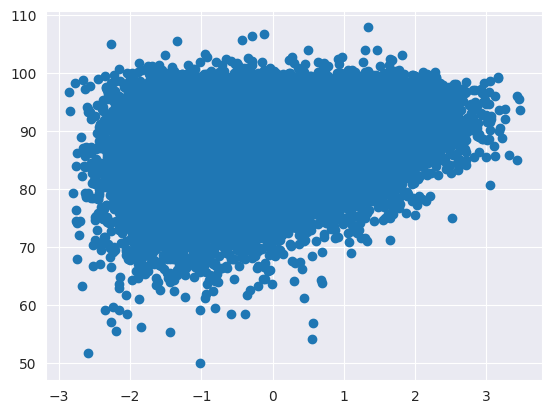

In [48]:
plt.scatter(test_elo,average_cpl_test)

In [49]:
# make a simple linear regression model.
regression = LinearRegression()
regression.fit(X_train,train_elo_transformed)
regression.score(X_test,test_elo)
y_pred = regression.predict(X_test)

In [50]:
mse_lin = mean_squared_error(test_elo_transformed, y_pred)

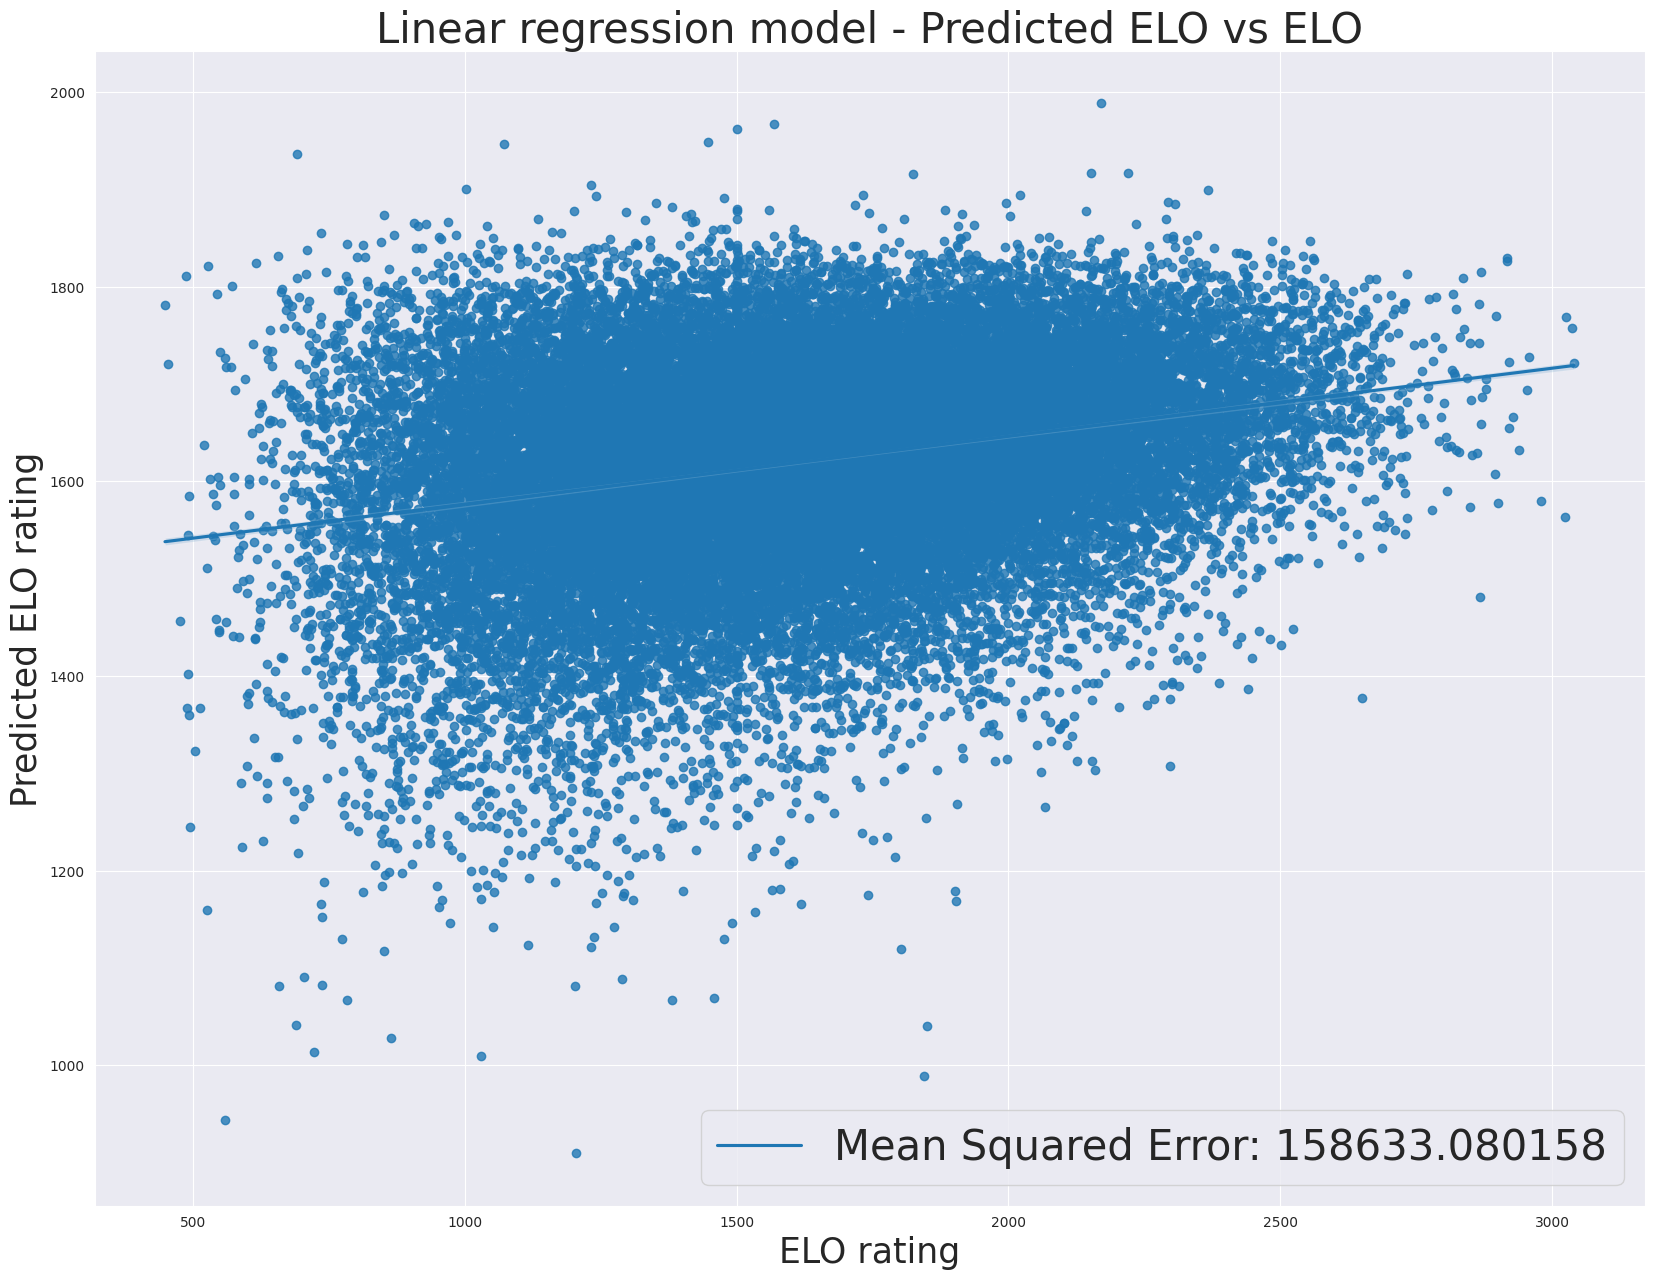

In [78]:
plt.figure(figsize = (20,15))
plt.title('Linear regression model - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = test_elo_transformed, y = y_pred, line_kws = {'label':f'Mean Squared Error: {mse_lin:4f}'})
plt.xlabel('ELO rating', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})

# Creating the Neural Network

In [52]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        target = [item[1] for item in batch]
        #print(f"TARGET: {target[7]}")
        white_lens = [i.shape[0] for i in white_data]
        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        #print("WHite data 2 shape",(white_data).size())
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)
        target = torch.tensor(target,dtype=torch.float64)
        return [white_evals_packed, target]

In [53]:
# defining parameters for the neural net
input_size = 6
hidden_size = 24
no_layers = 3
batch_size = 256

In [62]:
model = MyLSTM(input_size, hidden_size, no_layers)
#model.load_state_dict(torch.load('networks/main_model_epoch_111.pt'))
#model.load_state_dict(torch.load('networks/main_model_epoch_82.pt'))
collate = MyCollator()
print(model.parameters)

<bound method Module.parameters of MyLSTM(
  (lstm): LSTM(6, 24, num_layers=3, batch_first=True, dropout=0.6, bidirectional=True)
  (end): Linear(in_features=144, out_features=1, bias=False)
)>


# Training the model

In [63]:
# defining loss functions
@torch.compile(mode = 'max-autotune')
def custom_loss(outputs, elo):
    criterion = nn.MSELoss()
    l = criterion(outputs,elo)
    var = ((outputs - outputs.mean())**2).mean()
    elo_var = ((elo - elo.mean())**2).mean()
    z = (var-elo_var)**2#(torch.relu((var-elo_var)**2 - 2))
    
    # trying to match minima and maxima
    kurt = ((outputs - outputs.mean())**4).mean()
    elo_kurt = ((elo - elo.mean())**4).mean()
    k = (kurt-elo_kurt)**2  #torch.relu((kurt-elo_kurt)**2  - 10)
    return l+ k/20 + z/20

In [64]:
writer = SummaryWriter('runs/h45l4-2')

In [65]:
learning_rate = .000001

In [66]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [67]:
#criterion = nn.MSELoss()
#criterion = custom_loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [68]:
import torch.nn.utils as utils


In [61]:
import matplotlib.ticker as ticker


Test loss =  0.884564113105858
Epoch 63 step 544 - Learning Rate : 1e-06- Avg Loss: 0.854739 - Change in loss: 8.547388052010861


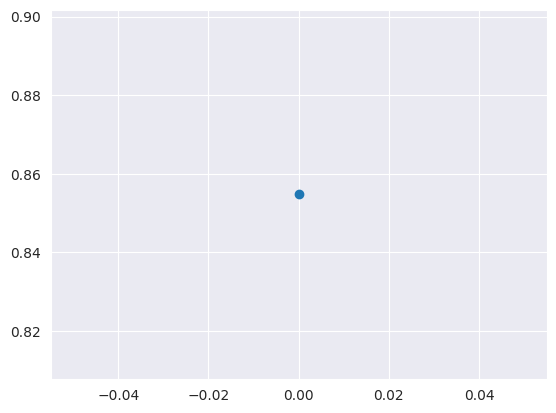

Test loss =  0.8851095150418982
Epoch 64 step 544 - Learning Rate : 1e-06- Avg Loss: 0.854313 - Change in loss: 0.9995019574509536


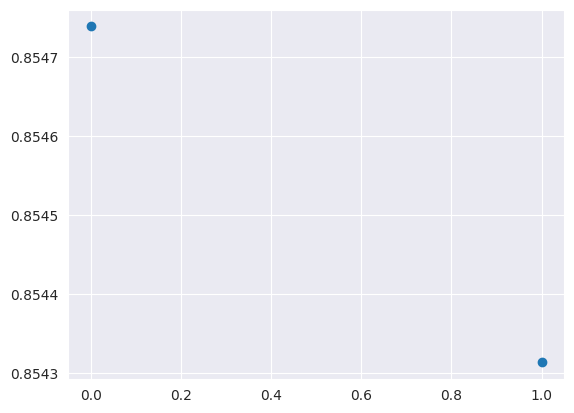

KeyboardInterrupt: 

In [152]:
avg_losses = []
epochs = []
avg_loss = 0.1


test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=batch_size, shuffle=False ,collate_fn=collate)

for epoch in range(1000):
    data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True,collate_fn=collate)
    losses = []
    model.train()
    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        #print(outputs)buy 
        loss = custom_loss(outputs,elo)
        # optimizing
        optimizer.zero_grad()
        loss.backward()
        #utils.clip_grad_norm_(model.parameters(), 1000)
        #for param in model.parameters():
            #param.grad = torch.clamp(param.grad, min=0.001)
        optimizer.step()
        losses.append(loss.item())
        i+=1


    #evaluating on the test data
    model.eval() 
    tlosses2= []
    for evals, elo in test_data_loader:
        evals = evals.to(device)
        elo = elo.to(device)
        output = model(evals)
        loss = custom_loss(output,elo)
        tlosses2.append(loss.item())
    print("Test loss = ",stats.mean(tlosses2))
    
    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',stats.mean(losses), epoch)
    avg_losses.append(stats.mean(losses))
    epochs.append(epoch)
    print(f'Epoch {epoch+1+62} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {stats.mean(losses):3f} - Change in loss: {change}')
    torch.save(model.state_dict(), f'networks/main_model_epoch_{epoch+1+62}.pt')
    formatter = ticker.ScalarFormatter(useMathText=False)
    formatter.set_scientific(False)
    
    # Apply the custom tick formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.scatter(epochs, avg_losses)
    plt.show()
writer.close() 

## Evaluating the model

In [69]:
model.eval()

MyLSTM(
  (lstm): LSTM(6, 24, num_layers=3, batch_first=True, dropout=0.6, bidirectional=True)
  (end): Linear(in_features=144, out_features=1, bias=False)
)

In [70]:
model.to(device)


MyLSTM(
  (lstm): LSTM(6, 24, num_layers=3, batch_first=True, dropout=0.6, bidirectional=True)
  (end): Linear(in_features=144, out_features=1, bias=False)
)

In [71]:
test_data_loader1 = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [72]:
# getting a list of outputs for the test data
outputs = []
elos = []
for evals, elo in test_data_loader1:
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
print(f'Average loss : {stats.mean(losses)}')

NameError: name 'losses' is not defined

In [73]:
# preparing data to be inverse transformed
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))


In [74]:
print(outputs.min())

-1.6170477304889017


In [75]:
# getting elos from the normalized values
elos = target_pt.inverse_transform(elos)
outputs = target_pt.inverse_transform(outputs)

In [76]:
mse_model = mean_squared_error(elos,outputs)

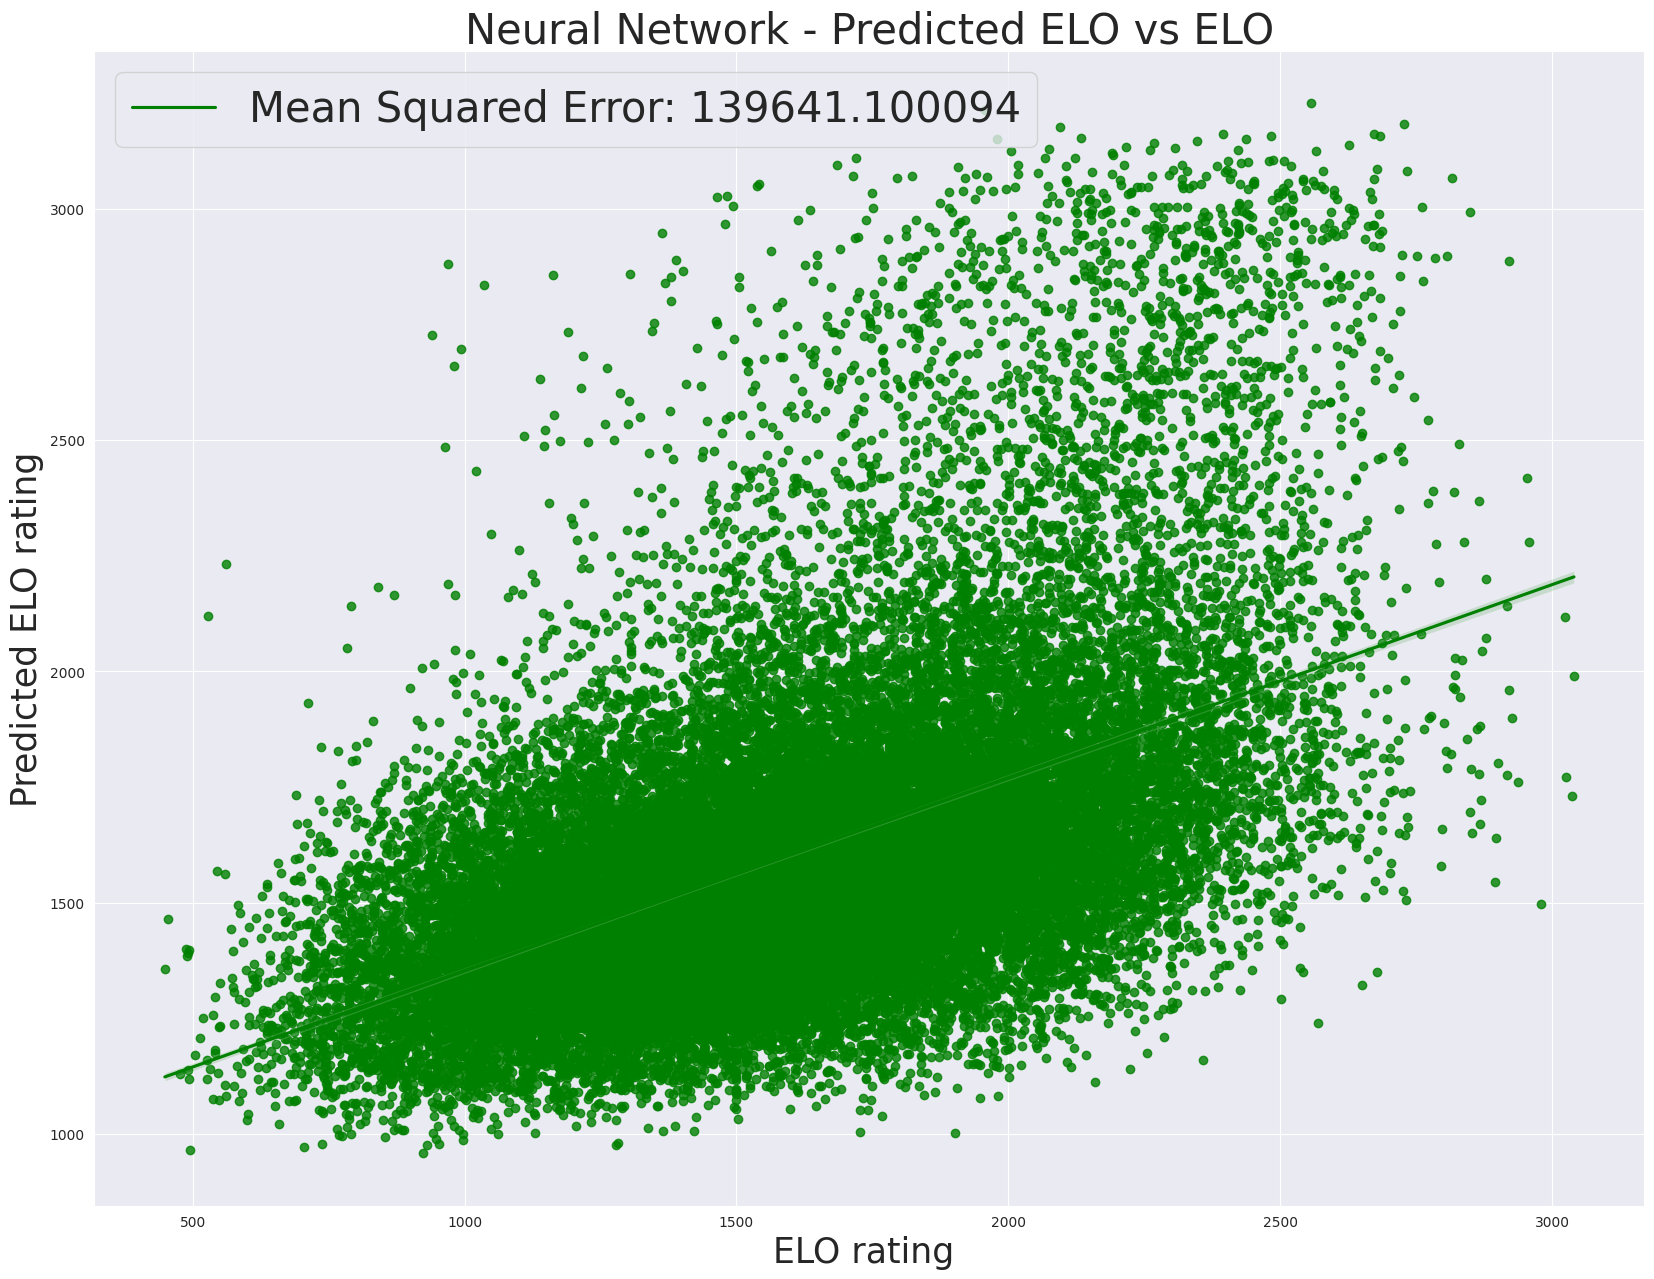

In [77]:
plt.figure(figsize = (20,15))
plt.title('Neural Network - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = elos, y = outputs, color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.xlabel('ELO rating ', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
#plt.savefig('images/NN_model_acc1.png')

In [143]:
torch

<module 'torch' from '/home/tadgh/PycharmProjects/webapp-venv/lib/python3.10/site-packages/torch/__init__.py'>

In [145]:
torch.save(model.state_dict(), 'main_model.pt')